In [64]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [65]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [66]:
NUM_CLASSES = 3

# Dataset reading

In [67]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2 * 2) + 1)))

In [68]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [70]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (803, 84)
y_train shape: (803,)
X_test shape: (268, 84)
y_test shape: (268,)


# Model building

In [71]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 * 2, )), # had to change for the two handed gestures
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [72]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,943 (7.59 KB)

 Trainable params: 1,943 (7.59 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [74]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [75]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.3047 - loss: 1.3198
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3089 - loss: 1.2820 - val_accuracy: 0.5261 - val_loss: 1.0239
Epoch 2/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3203 - loss: 1.1533
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3544 - loss: 1.1077 - val_accuracy: 0.5522 - val_loss: 0.9600
Epoch 3/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5391 - loss: 0.9451
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4873 - loss: 0.9821 - val_accuracy: 0.5522 - val_loss: 0.8980
Epoch 4/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5156 - loss: 0.9663
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━

In [76]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9723 - loss: 0.1598


In [77]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [78]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8.6685216e-01 6.5005943e-04 1.3249780e-01]
0


# Confusion matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


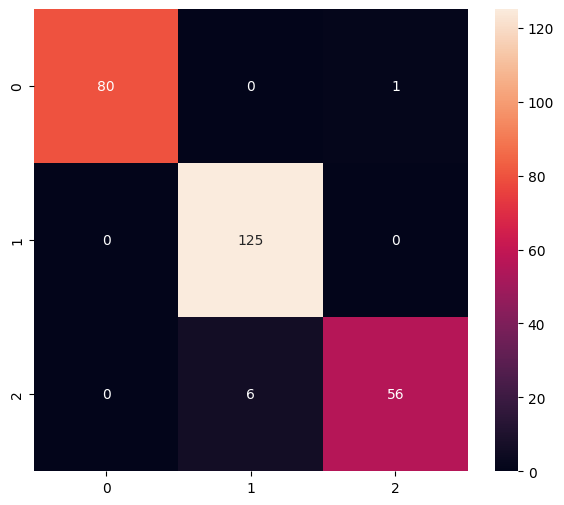

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        81
           1       0.95      1.00      0.98       125
           2       0.98      0.90      0.94        62

    accuracy                           0.97       268
   macro avg       0.98      0.96      0.97       268
weighted avg       0.97      0.97      0.97       268



In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [80]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [81]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/g0/vmrv2cbj6tn_m8kjq9znrq9c0000gn/T/tmp9jifshek/assets


INFO:tensorflow:Assets written to: /var/folders/g0/vmrv2cbj6tn_m8kjq9znrq9c0000gn/T/tmp9jifshek/assets


Saved artifact at '/var/folders/g0/vmrv2cbj6tn_m8kjq9znrq9c0000gn/T/tmp9jifshek'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 84), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13358953104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13358953872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13358954832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13358949840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13358944464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13358952336: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1726286713.457830 3343913 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1726286713.457900 3343913 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


5160

# Inference test

In [82]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [83]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [84]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [85]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 270 μs, sys: 256 μs, total: 526 μs
Wall time: 352 μs


In [86]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.6813653e-01 6.4892188e-04 1.3121459e-01]
0
